In [1]:
import requests
import json
import os
import datetime
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
%matplotlib inline

In [2]:
load_dotenv()

True

In [3]:
crypcomp_api_key = os.getenv('CRYPTOCOMPARE_API_KEY')

In [4]:
api_req = "https://min-api.cryptocompare.com/data/v2/histoday?fsym="

In [5]:
btc_req = requests.get(api_req+'BTC&tsym=USD&limit=2000')
btc_historical_val = pd.DataFrame(json.loads(btc_req.content)['Data']['Data']).drop(columns={'conversionType','conversionSymbol'})
btc_historical_val = btc_historical_val[(btc_historical_val != 0).all(1)]
btc_historical_val['ohlc_avg'] = (btc_historical_val['high'] + btc_historical_val['low'] + btc_historical_val['open'] + btc_historical_val['close'])/4
btc_historical_val['oc_avg'] = (btc_historical_val['close'] - btc_historical_val['open'])/btc_historical_val['open']
btc_historical_val['volatility'] = (btc_historical_val['high'] - btc_historical_val['low']) / btc_historical_val['open']
btc_historical_val = btc_historical_val.set_index('time')
btc_historical_val.index = pd.to_datetime(btc_historical_val.index, unit='s')
btc_historical_val.shape

(2001, 9)

In [6]:
btc_historical_val

,high,low,open,volumefrom,volumeto,close,ohlc_avg,oc_avg,volatility
time,,,,,,,,,
2015-07-27,295.79,285.40,291.77,69710.58,2.035833e+07,293.01,291.4925,0.004250,0.035610
2015-07-28,296.68,291.67,293.01,49065.80,1.446643e+07,293.70,293.7650,0.002355,0.017098
2015-07-29,294.72,286.89,293.70,50673.64,1.473822e+07,288.37,290.9200,-0.018148,0.026660
2015-07-30,289.89,284.91,288.37,44792.49,1.288868e+07,287.02,287.5475,-0.004681,0.017269
2015-07-31,288.69,280.77,287.02,49212.01,1.401907e+07,283.73,285.0525,-0.011463,0.027594
...,...,...,...,...,...,...,...,...,...
2021-01-12,36620.28,32522.98,35496.03,115232.53,3.999536e+09,34058.40,34674.4225,-0.040501,0.115430
2021-01-13,37809.67,32405.89,34058.40,91979.17,3.198683e+09,37380.85,35413.7025,0.097552,0.158662
2021-01-14,40093.43,36751.89,37380.85,74972.21,2.895085e+09,39155.58,38345.4375,0.047477,0.089392


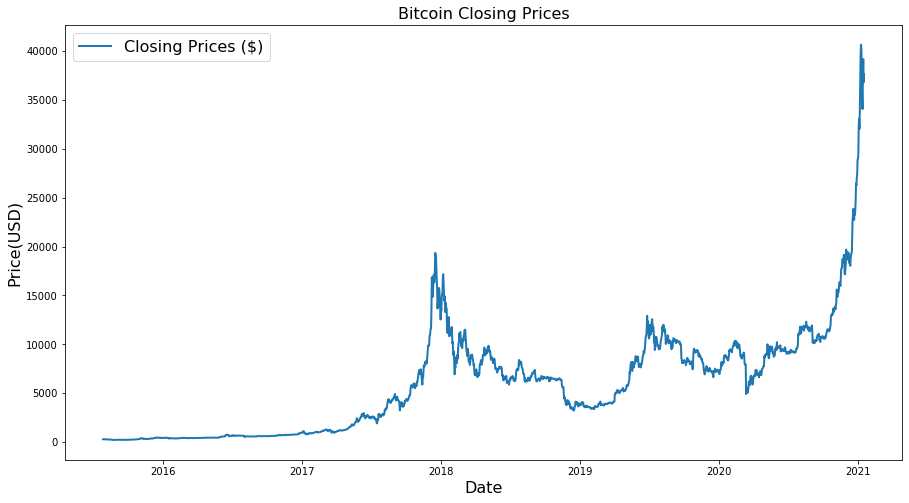

In [7]:
#Bitcoin closing prices
fig, ax = plt.subplots(1, figsize=(15,8))
ax.plot(btc_historical_val['close'], label='Closing Prices ($)', linewidth=2)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Price(USD)', fontsize=16)
ax.set_title('Bitcoin Closing Prices', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [8]:
eth_req = requests.get(api_req+'ETH&tsym=USD&limit=2000')
eth_historical_val = pd.DataFrame(json.loads(eth_req.content)['Data']['Data']).drop(columns={'conversionType','conversionSymbol'})
eth_historical_val = eth_historical_val[(eth_historical_val != 0).all(1)]
eth_historical_val['ohlc_avg'] = (eth_historical_val['high'] + eth_historical_val['low'] + eth_historical_val['open'] + eth_historical_val['close'])/4
eth_historical_val['oc_avg'] = (eth_historical_val['close'] - eth_historical_val['open'])/eth_historical_val['open']
eth_historical_val['volatility'] = (eth_historical_val['high'] - eth_historical_val['low']) / eth_historical_val['open']
eth_historical_val = eth_historical_val.set_index('time')
eth_historical_val.index = pd.to_datetime(eth_historical_val.index, unit='s')
eth_historical_val.shape

(1990, 9)

In [9]:
eth_historical_val

,high,low,open,volumefrom,volumeto,close,ohlc_avg,oc_avg,volatility
time,,,,,,,,,
2015-08-07,27.7900,0.7809,0.7812,53584.56,1.486083e+05,2.7730,8.031275,2.549667,34.573861
2015-08-08,2.5810,0.5958,2.7730,722558.00,5.835435e+05,0.8076,1.689350,-0.708763,0.715903
2015-08-09,0.9581,0.6043,0.8076,737119.57,5.475280e+05,0.7428,0.778200,-0.080238,0.438088
2015-08-10,0.7628,0.5990,0.7428,585917.04,4.011071e+05,0.6846,0.697300,-0.078352,0.220517
2015-08-11,1.1650,0.6548,0.6846,1479695.62,1.567649e+06,1.0590,0.890850,0.546889,0.745253
...,...,...,...,...,...,...,...,...,...
2021-01-12,1149.8700,1007.6800,1088.3700,1521509.38,1.647584e+09,1050.0400,1073.990000,-0.035218,0.130645
2021-01-13,1136.6600,985.3200,1050.0400,1182504.51,1.262995e+09,1129.8400,1075.465000,0.075997,0.144128
2021-01-14,1246.3600,1087.3900,1129.8400,1151856.90,1.349158e+09,1232.1100,1173.925000,0.090517,0.140701


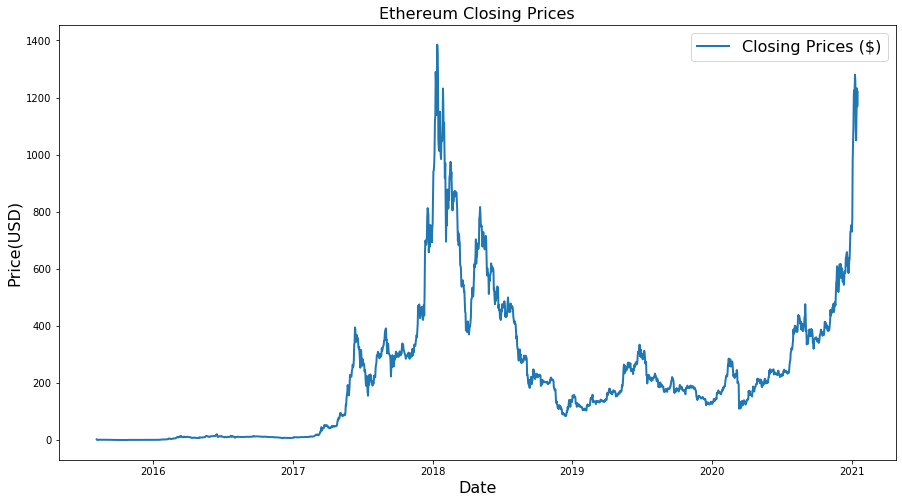

In [10]:
#Ethereum closing prices
fig, ax = plt.subplots(1, figsize=(15,8))
ax.plot(eth_historical_val['close'], label='Closing Prices ($)', linewidth=2)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Price(USD)', fontsize=16)
ax.set_title('Ethereum Closing Prices', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [11]:
#Function to split data into training/test sets with a 20% weight
def train_test(df, test_size):
    split = len(df) - int(test_size * len(df))
    train = df.iloc[:split]
    test = df.iloc[split:]
    return train, test

In [12]:
#Bitcoin/Ethereum train/test split
btc_train, btc_test = train_test(btc_historical_val, test_size=0.2)
eth_train, eth_test = train_test(eth_historical_val, test_size=0.2)
btc_test

,high,low,open,volumefrom,volumeto,close,ohlc_avg,oc_avg,volatility
time,,,,,,,,,
2019-12-14,7283.78,7033.14,7261.72,15624.21,1.117969e+08,7080.29,7164.7325,-0.024984,0.034515
2019-12-15,7204.93,7030.37,7080.29,15972.70,1.137429e+08,7132.39,7111.9950,0.007358,0.024654
2019-12-16,7172.46,6869.19,7132.39,39619.58,2.782233e+08,6897.33,7017.8425,-0.032957,0.042520
2019-12-17,6948.12,6585.46,6897.33,46023.51,3.107396e+08,6635.84,6766.6875,-0.037912,0.052580
2019-12-18,7442.26,6450.69,6635.84,71573.09,4.914296e+08,7294.53,6955.8300,0.099262,0.149426
...,...,...,...,...,...,...,...,...,...
2021-01-12,36620.28,32522.98,35496.03,115232.53,3.999536e+09,34058.40,34674.4225,-0.040501,0.115430
2021-01-13,37809.67,32405.89,34058.40,91979.17,3.198683e+09,37380.85,35413.7025,0.097552,0.158662
2021-01-14,40093.43,36751.89,37380.85,74972.21,2.895085e+09,39155.58,38345.4375,0.047477,0.089392


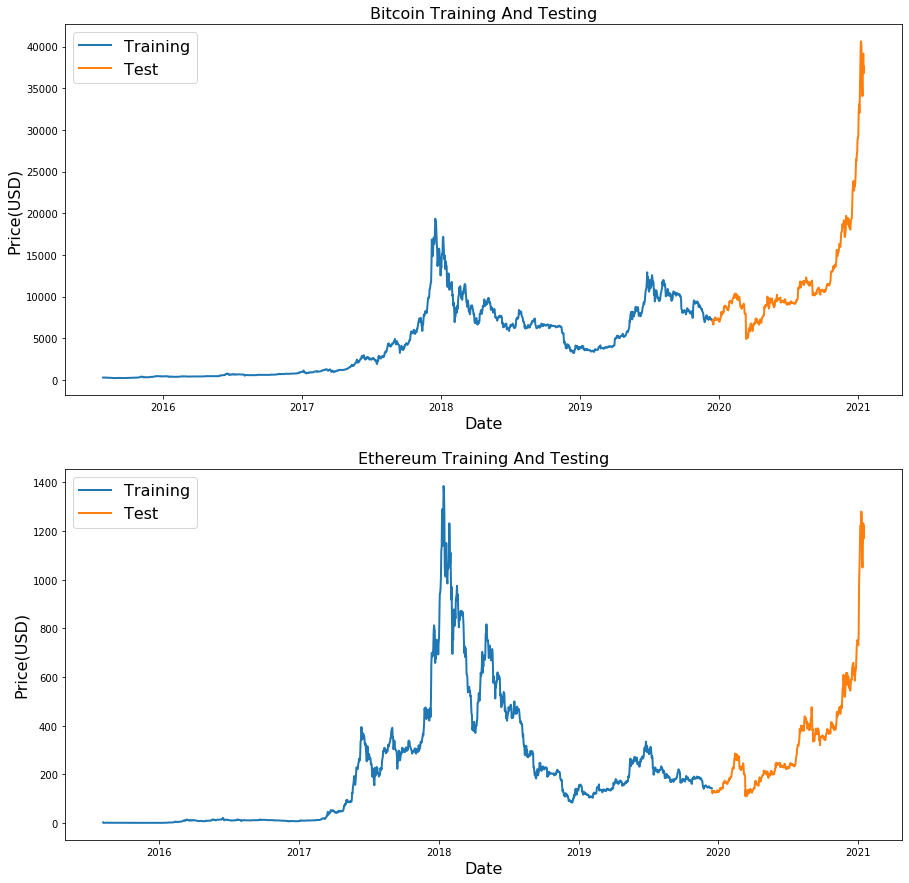

In [13]:
#Plot training/test split of btc/eth
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,15))
ax1.plot(btc_train['close'], label='Training', linewidth=2)
ax2.plot(eth_train['close'], label='Training', linewidth=2)
ax1.plot(btc_test['close'], label='Test', linewidth=2)
ax2.plot(eth_test['close'], label='Test', linewidth=2)
ax1.set_xlabel('Date', fontsize=16)
ax2.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Price(USD)', fontsize=16)
ax2.set_ylabel('Price(USD)', fontsize=16)
ax1.set_title('Bitcoin Training And Testing', fontsize=16)
ax2.set_title('Ethereum Training And Testing', fontsize=16)
ax1.legend(loc='best', fontsize=16)
ax2.legend(loc='best', fontsize=16)

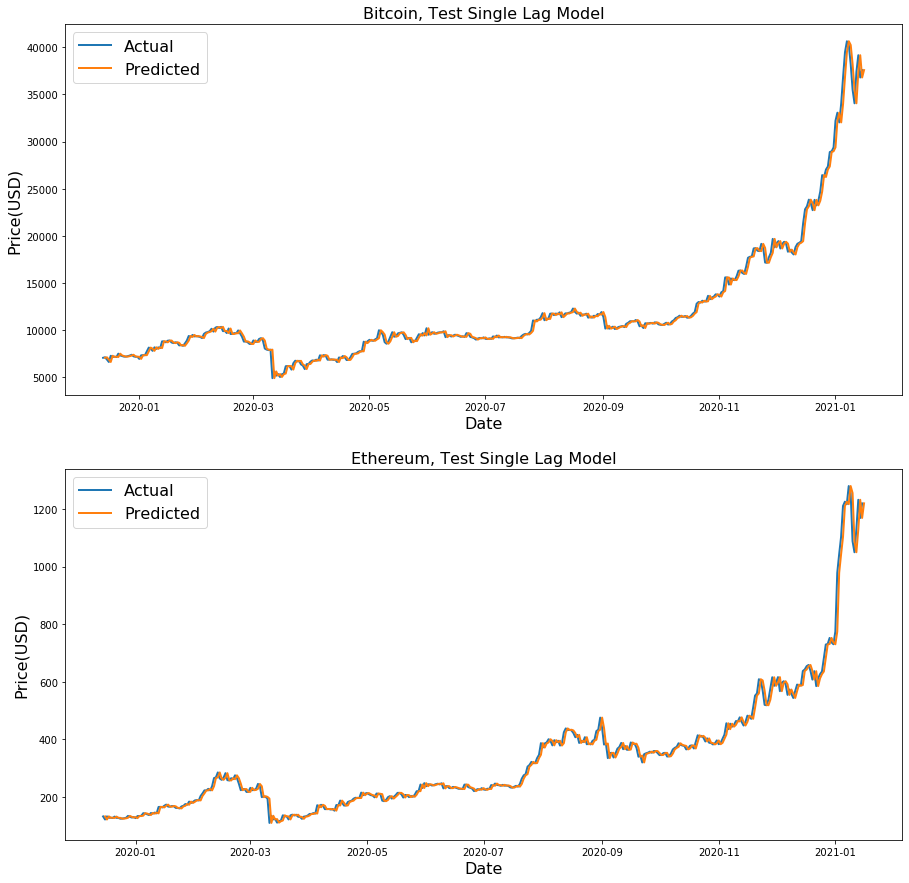

In [14]:
#Single lag model
btc_test_lag = btc_test.set_index(pd.DatetimeIndex(btc_test.index) - pd.DateOffset(1))
eth_test_lag = eth_test.set_index(pd.DatetimeIndex(eth_test.index) - pd.DateOffset(1))
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,15))
#pd.DatetimeIndex(btc_test.index) - pd.DateOffset(1)
ax1.plot(btc_test_lag['close'], label='Actual', linewidth=2)
ax2.plot(eth_test_lag['close'], label='Actual', linewidth=2)
ax1.plot(btc_test['close'], label='Predicted', linewidth=2)
ax2.plot(eth_test['close'], label='Predicted', linewidth=2)
ax1.set_xlabel('Date', fontsize=16)
ax2.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Price(USD)', fontsize=16)
ax2.set_ylabel('Price(USD)', fontsize=16)
ax1.set_title('Bitcoin, Test Single Lag Model', fontsize=16)
ax2.set_title('Ethereum, Test Single Lag Model', fontsize=16)
ax1.legend(loc='best', fontsize=16)
ax2.legend(loc='best', fontsize=16)
plt.show()

In [26]:
def normalise_zero(df):
    """ 
    Normalise dataframe column wise to scalar index 
    """
    return df / df.iloc[0] - 1

def window_sequence(df, window=10, zero_base=True):
    """ 
    Dataframe conversion to sequence of length of 'window'
    """
    window_data = []
    for idx in range(len(df) - window):
        tmp = df[idx: (idx + window)].copy()
        if zero_base:
            tmp = normalise_zero(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def data_preperation(df,target_col, window=10, zero_base=True, test_size=0.2):
    """ LSTM data prepreratiom """
    
    train_data, test_data = train_test_split(df, test_size=test_size)
    
    # extract window data
    X_train = window_sequence(train_data, window, zero_base)
    X_test = window_sequence(test_data, window, zero_base)
    
    # extract targets
    y_train = train_data[target_col][window:].values
    y_test = test_data[target_col][window:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window].values - 1
        y_test = y_test / test_data[target_col][:-window].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [16]:
def model_lstm_builder(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [17]:
btc_historical_orig = pd.DataFrame(json.loads(btc_req.content)['Data']['Data']).drop(columns={'conversionType','conversionSymbol'})
btc_historical_orig = btc_historical_orig.set_index('time')
btc_historical_orig.index = pd.to_datetime(btc_historical_orig.index, unit='s')
btc_historical_orig = btc_historical_orig[['close', 'high', 'low', 'open', 'volumefrom', 'volumeto']]

In [18]:
eth_historical_orig = pd.DataFrame(json.loads(eth_req.content)['Data']['Data']).drop(columns={'conversionType','conversionSymbol'})
eth_historical_orig = eth_historical_orig.set_index('time')
eth_historical_orig = eth_historical_orig[(eth_historical_orig != 0).all(1)]
eth_historical_orig.index = pd.to_datetime(eth_historical_orig.index, unit='s')
eth_historical_orig = eth_historical_orig[['close', 'high', 'low', 'open', 'volumefrom', 'volumeto']]

In [27]:
np.random.seed(45)

#params
window = 7
test_size = 0.1
zero_base = True
neurons = 20
epochs = 50
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'
target_close='close'

In [20]:
bit_train, bit_test, bit_X_train, bit_X_test, bit_y_train, bit_y_test = data_preperation(
    btc_historical_orig, target_col=target_close, window=window, zero_base=zero_base, test_size=test_size)

In [22]:
btc_model = model_lstm_builder(bit_X_train, 
                             output_size=1, 
                             neurons=neurons, 
                             dropout=dropout, 
                             loss=loss,
                             optimizer=optimizer)
btc_fit = btc_model.fit(
    bit_X_train, bit_y_train, epochs=50, batch_size=4, verbose=1, shuffle=True)

Epoch 1/50
449/449 [==============================] - 3s 8ms/step - loss: 3.7841
Epoch 2/50
449/449 [==============================] - 3s 7ms/step - loss: 3.5912
Epoch 3/50
449/449 [==============================] - 4s 8ms/step - loss: 3.5018
Epoch 4/50
449/449 [==============================] - 4s 8ms/step - loss: 3.4424
Epoch 5/50
449/449 [==============================] - 4s 8ms/step - loss: 3.4773
Epoch 6/50
449/449 [==============================] - 3s 7ms/step - loss: 3.4411
Epoch 7/50
449/449 [==============================] - 4s 8ms/step - loss: 3.3820
Epoch 8/50
449/449 [==============================] - 3s 8ms/step - loss: 3.3556
Epoch 9/50
449/449 [==============================] - 4s 8ms/step - loss: 3.3512
Epoch 10/50
449/449 [==============================] - 4s 9ms/step - loss: 3.3620
Epoch 11/50
449/449 [==============================] - 4s 9ms/step - loss: 3.3139
Epoch 12/50
449/449 [==============================] - 4s 8ms/step - loss: 3.3215
Epoch 13/50
449/449 [====

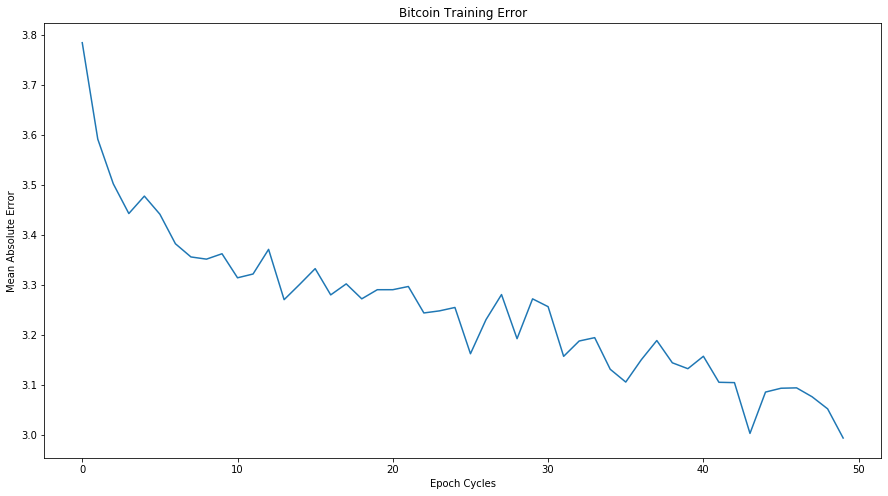

In [31]:
fig, ax = plt.subplots(1,figsize=(15,8))
ax.plot(btc_fit.epoch, btc_fit.history['loss'])
ax.set_ylabel("Mean Absolute Error")
ax.set_xlabel("Epoch Cycles")
ax.set_title("Bitcoin Training Error")
plt.show()

In [24]:
eth_train, eth_test, eth_X_train, eth_X_test, eth_y_train, eth_y_test = data_preperation(
    eth_historical_orig, target_col=target_close, window=window, zero_base=zero_base, test_size=test_size)

In [25]:
eth_model = model_lstm_builder(eth_X_train, 
                             output_size=1, 
                             neurons=20, 
                             dropout=0.25, 
                             loss='mae',
                             optimizer='adam')
eth_fit = eth_model.fit(
    eth_X_train, eth_y_train, epochs=50, batch_size=4, verbose=1, shuffle=True)

Epoch 1/50
446/446 [==============================] - 3s 6ms/step - loss: 26.7882
Epoch 2/50
446/446 [==============================] - 2s 5ms/step - loss: 26.2977
Epoch 3/50
446/446 [==============================] - 2s 5ms/step - loss: 26.0061
Epoch 4/50
446/446 [==============================] - 2s 5ms/step - loss: 25.7592
Epoch 5/50
446/446 [==============================] - 2s 6ms/step - loss: 25.6465
Epoch 6/50
446/446 [==============================] - 2s 5ms/step - loss: 25.5614
Epoch 7/50
446/446 [==============================] - 2s 5ms/step - loss: 25.3931
Epoch 8/50
446/446 [==============================] - 2s 5ms/step - loss: 25.4209
Epoch 9/50
446/446 [==============================] - 2s 5ms/step - loss: 25.3633
Epoch 10/50
446/446 [==============================] - 2s 5ms/step - loss: 25.3847
Epoch 11/50
446/446 [==============================] - 2s 5ms/step - loss: 25.2273
Epoch 12/50
446/446 [==============================] - 2s 5ms/step - loss: 25.2382
Epoch 13/50
4

In [ ]:
fig, ax = plt.subplot(1,1)
ax.plot()

In [ ]:
#Ethereum Normalization On 'Close'
eth_historical_norm = eth_historical_val.drop(columns={'high','low','open','ohlc_avg'})
scaler = MinMaxScaler(feature_range=(0, 1))
eth_historical_norm = scaler.fit_transform(eth_historical_norm)
eth_historical_norm = pd.DataFrame(eth_historical_norm)
eth_historical_norm

In [ ]:
#Bitcoin Normalization On 'Close'
scaler = MinMaxScaler(feature_range=(0, 1))
btc_historical_norm = scaler.fit_transform(btc_historical_val)
btc_historical_norm = pd.DataFrame(btc_historical_norm)
btc_historical_norm.describe()